In [1]:
##This is a pytorch implement for HybridSN 
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
import numpy as np
import matplotlib.pyplot as plt
import spectral
import random
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,recall_score,cohen_kappa_score,accuracy_score
from scipy.io import loadmat
import os
from tqdm.notebook import tqdm
%matplotlib inline

torch：PyTorch 深度学习框架，用于构建神经网络模型和进行深度学习任务。

torch.nn：PyTorch 中用于构建神经网络的模块。

torch.utils.data：PyTorch 中用于处理数据集和数据加载的模块。

torchinfo：一个用于获取 PyTorch 模型信息的库，可以查看模型的结构和参数数量等信息。

os：Python 中用于提供与操作系统交互的功能的库。

tqdm.notebook：一个用于在 Jupyter Notebook 中显示循环进度条的库。

In [2]:
##hypeperameters and experimental settings
RANDOM_SEED=666
DATASET = 'Houston13'    
TRAIN_RATE = 0.3  ## ratio of training data
VAL_RATE = 0.1    ## ratio of valuating data
EPOCH = 100    ##number of epoch
VAL_EPOCH = 5  ##interval of valuation
LR = 0.001    ##learning rate
WEIGHT_DECAY = 1e-6  
BATCH_SIZE = 256
DEVICE = 0  ##-1:CPU  0:cuda 0
N_PCA = 15  ## reserved PCA components
PATCH_SIZE = 25 
SAVE_PATH = f"results\\{DATASET}"
if not os.path.isdir(SAVE_PATH):
    os.mkdir(SAVE_PATH)

RANDOM_SEED=666：设置了一个随机种子，用于在需要随机性的地方确保实验的可重复性。

DATASET = 'SA'：指定了数据集的名称。

TRAIN_RATE = 0.3：设置了训练数据集所占整体数据集的比例，这里是 30%。

VAL_RATE = 0.1：设置了验证数据集所占整体数据集的比例，这里是 10%。

EPOCH = 100：设置了训练的轮数，也就是训练的迭代次数。

VAL_EPOCH = 5：设置了每隔多少个 epoch 进行一次验证（evaluation）。

LR = 0.001：设置了学习率，用于控制模型参数更新的步长。

>学习率（Learning Rate，LR）是深度学习中的一个重要超参数，用于控制模型在每次迭代中更新权重的步长大小。在训练神经网络时，通过梯度下降算法来更新模型的权重，学习率决定了在每次更新中权重应该移动的距离。

WEIGHT_DECAY = 1e-6：设置了权重衰减（weight decay）的值，用于控制模型参数的正则化。
>权重衰减（Weight Decay）是一种常用的正则化技术，用于减小模型的复杂度，防止过拟合。在神经网络的训练过程中，权重衰减通过对损失函数添加一个正则化项来实现。这个正则化项通常是权重的平方和或者绝对值的和，乘以一个称为权重衰减系数（通常用 λ 表示）的常数。

BATCH_SIZE = 256：设置了每个批次（batch）中包含的样本数量。

DEVICE = 0：指定了模型训练的设备，-1 表示使用 CPU，0 表示使用 CUDA 设备 0（GPU）。

N_PCA = 15：设置了保留的 PCA 主成分的数量。

PATCH_SIZE = 25：设置了图像或数据的块（patch）的大小。

SAVE_PATH = f"results\\{DATASET}"：根据数据集的名称构建了保存结果的文件夹路径。
>这行代码是Python中的字符串格式化语法，用于生成保存路径。假设在代码中已经定义了变量DATASET，表示数据集的名称，那么这行代码会将数据集的名称插入到字符串中，生成一个保存路径。

>具体来说，f"results\\{DATASET}" 中的 f 表示这是一个格式化字符串，{DATASET} 是一个占位符，表示将变量 DATASET 的值插入到这个位置。假设 DATASET 的值为 "my_dataset"，那么这行代码的结果就是 "results\\my_dataset"。

if not os.path.isdir(SAVE_PATH): os.mkdir(SAVE_PATH)：检查保存结果的文件夹是否存在，如果不存在则创建该文件夹。

In [3]:
## Set random seed for reproduction
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

random.seed(RANDOM_SEED)：设置 Python 内置的随机数生成器的种子，用于控制随机数的生成。

torch.manual_seed(RANDOM_SEED)：设置 PyTorch 的随机数种子，以确保在使用 PyTorch 进行随机操作时的可重复性。

torch.cuda.manual_seed(RANDOM_SEED)：设置当前 CUDA 设备的随机种子，以确保在使用 CUDA 进行随机操作时的可重复性。

torch.cuda.manual_seed_all(RANDOM_SEED)：设置所有可用的 CUDA 设备的随机种子，以确保在使用多个 CUDA 设备时的可重复性。

np.random.seed(RANDOM_SEED)：设置 NumPy 库的随机数种子，以确保在使用 NumPy 进行随机操作时的可重复性。

torch.backends.cudnn.deterministic = True：设置 PyTorch 的 cuDNN 库的随机性为确定性模式，以确保在使用 cuDNN 加速时的可重复性。

torch.backends.cudnn.benchmark = False：禁用 cuDNN 的基准模式，以确保在使用 cuDNN 加速时的可重复性。

In [4]:
import os
import h5py

def loadData(name):
    data_path = os.path.join(os.getcwd(), 'dataset')
    data_file = os.path.join(data_path, name + '.mat')
    label_file = os.path.join(data_path, name + '_7gt.mat')
    
    with h5py.File(data_file, 'r') as f:
        data = f['ori_data'][:]  # 使用正确的数据集名称来访问数据

    with h5py.File(label_file, 'r') as f:
        label = f['map'][:]  # 使用正确的标签数据集名称来访问标签

    class_name = ["Grass-healthy", "Grass-stressed", "Trees", "Water", 
                  "Residential-buildings", "Non-residential-buildings", "Road"]
    
    return data, label, class_name

data_path = os.path.join(os.getcwd(),'dataset')：构建了数据集所在文件夹的路径，这里假设数据集存储在当前工作目录下的 dataset 文件夹中。

接下来是加载不同的数据集,分别加载了数据和标签，并设置了对应的类别名称列表 class_name。

最后，函数返回加载的数据、标签和类别名称列表。

In [5]:
import h5py

# 打开HDF5文件
file_path = 'dataset\\Houston13_7gt.mat' 
with h5py.File(file_path, 'r') as f:
    # 遍历文件中的数据集和组
    def print_attrs(name, obj):
        print(name)
        for key, val in obj.attrs.items():
            print("    %s: %s" % (key, val))

    f.visititems(print_attrs)

map
    MATLAB_class: b'double'


用于确认文件的数据集结构

In [6]:
data, label, class_name = loadData(DATASET)
NUM_CLASS = label.max()

在这段代码中，loadData(DATASET) 函数被调用，其中 DATASET 是一个变量或者常量，用于指定要加载的数据集名称。函数返回了三个值：data、label 和 class_name。

data 是加载的数据集。

label 是加载的数据集对应的标签。

class_name 是数据集中类别的名称列表。

接下来的代码是 NUM_CLASS = label.max()，它的作用是计算标签中的最大值，即数据集中的类别数量。这个值将作为后续处理中需要用到的类别数量。在这里，假设标签是从 1 开始编号的，因此最大的标签值就是类别的数量。

In [7]:
print(data.shape)
print(label.shape)

(48, 954, 210)
(954, 210)


In [8]:
data = np.transpose(data, (1, 2, 0))
print(data.shape)
print(label.shape)

(954, 210, 48)
(954, 210)


确认图像的大小，并调整data以匹配函数

（imshow函数按照（hight,width,bands）的顺序）

C:\Users\lenovo\anaconda3\Lib\site-packages\spectral\graphics\spypylab.py:796: UserWarning: Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.
  warnings.warn(msg)


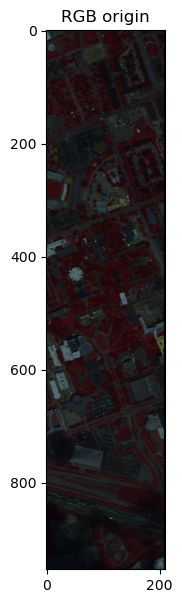

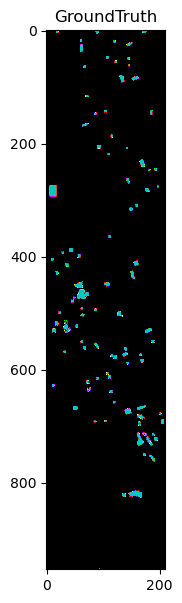

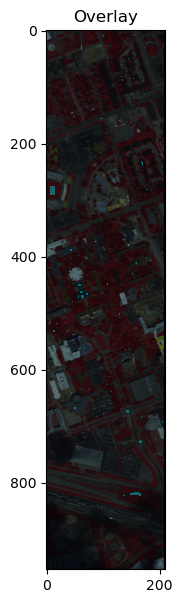

In [9]:
## display HSI
rgb_view=spectral.imshow(data,(30,20,10),classes=label,title='RGB origin',figsize=(7,7))
gt_view = spectral.imshow(classes=label, title='GroundTruth',figsize=(7,7))
view = spectral.imshow(data,(30,20,10),classes=label,figsize=(7,7))
view.set_display_mode('overlay')
view.class_alpha = 0.5
view.set_title('Overlay')
spectral.save_rgb(f'results/{DATASET}_RGB_origin.jpg',data,(30,20,10))
spectral.save_rgb(f'results/{DATASET}_gt.jpg',label,colors = spectral.spy_colors)

这段代码使用了 Python 中的 Spectral Python 库来展示和保存加载的高光谱图像数据和标签。

1. `rgb_view = spectral.imshow(data, (30, 20, 10), classes=label, title='RGB origin', figsize=(7, 7))`：这行代码创建了一个 RGB 彩色图像的显示窗口，并显示了原始的高光谱图像数据。参数 `(30, 20, 10)` 是用来定义 RGB 图像的波段组合，`classes=label` 用于指定颜色编码的类别标签，`title='RGB origin'` 用于设置窗口标题，`figsize=(7, 7)` 用于设置窗口大小。

2. `gt_view = spectral.imshow(classes=label, title='GroundTruth', figsize=(7, 7))`：这行代码创建了一个显示窗口，用于展示数据集的地面真实标签（Ground Truth）。`classes=label` 用于指定颜色编码的类别标签，`title='GroundTruth'` 用于设置窗口标题，`figsize=(7, 7)` 用于设置窗口大小。

3. `view = spectral.imshow(data, (30, 20, 10), classes=label, figsize=(7, 7))`：这行代码创建了一个显示窗口，展示了原始高光谱图像数据和标签。参数设置与第一行代码类似。

4. `view.set_display_mode('overlay')`：将显示模式设置为叠加显示。

5. `view.class_alpha = 0.5`：设置类别的透明度为 0.5。

6. `view.set_title('Overlay')`：设置窗口标题为 "Overlay"。

7. `spectral.save_rgb(f'results/{DATASET}_RGB_origin.jpg', data, (30, 20, 10))`：将原始的高光谱图像数据保存为 RGB 彩色图像。

8. `spectral.save_rgb(f'results/{DATASET}_gt.jpg', label, colors=spectral.spy_colors)`：将标签数据保存为彩色图像。

这段代码的作用是展示和保存加载的高光谱图像数据和标签。通过这些代码，可以直观地查看数据集的图像和标签信息，并保存为图像文件。

In [10]:
# show 3D cube
#%matplotlib auto
#spectral.view_cube(data,(30,20,10))   
# depend on wxpython and pyopengl

在新窗口中显示3D图形

In [11]:
def applyPCA(X, numComponents=15):
    """PCA processing

    Args:
        X (ndarray M*N*C): data needs DR
        numComponents (int, optional): number of reserved components. Defaults to 15.

    Returns:
        newX: _description_
    """
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)   ##PCA and normalization
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

def applyPCA(X, numComponents=15):
    """PCA处理

    Args:
        X (ndarray M*N*C): 需要进行降维处理的数据
        numComponents (int, optional): 保留的主成分数量，默认为15个。

    Returns:
        newX: _description_
    """
这是一个名为 applyPCA 的函数定义，它接受一个名为 X 的数组作为输入，并且有一个可选参数 numComponents，默认值为 15。函数文档提供了关于输入参数和返回值的信息。

    newX = np.reshape(X, (-1, X.shape[2]))
这一行将输入数组 X 重新塑造为一个二维数组，其中行数为 -1，列数为 X 的第三个维度的大小。这样做可以将原始的三维数据转换为二维以便进行PCA处理。

    pca = PCA(n_components=numComponents, whiten=True)   ##PCA and normalization
在这里，创建了一个PCA（主成分分析）对象，指定了主成分的数量为 numComponents，并且将 whiten 参数设置为 True，表示进行白化处理。白化是一种预处理技术，用于对输入特征进行去相关化和归一化处理。

    newX = pca.fit_transform(newX)
使用 fit_transform 方法对重塑后的数组 newX 进行PCA处理，得到降维后的数组 newX。

    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
在PCA处理完成后，将降维后的数组 newX 重新调整为原始的三维形状，其中第三个维度对应于PCA得到的主成分数量。

    return newX, pca
最后，函数返回经过PCA处理后的数据 newX 和PCA模型对象 pca。

In [12]:
data,pca = applyPCA(data,N_PCA)
data.shape

(954, 210, 15)

这段代码首先调用了名为 applyPCA 的函数，传入了 data 和 N_PCA 作为参数。

这个函数会对 data 进行PCA处理，并返回处理后的数据 data 和PCA模型对象 pca。

接着，data.shape 用于获取经过PCA处理后的数据 data 的形状，并打印出来。

所以，这段代码的作用是对 data 进行PCA处理，然后打印出处理后的数据 data 的形状。

In [13]:
def sample_gt(gt, train_rate):
    """ generate training gt for training dataset
    Args:
        gt (ndarray): full classmap
        train_rate (float): ratio of training dataset
    Returns:
        train_gt(ndarray): classmap of training data
        test_gt(ndarray): classmap of test data
    """
    indices = np.nonzero(gt)  ##([x1,x2,...],[y1,y2,...])
    X = list(zip(*indices))  ## X=[(x1,y1),(x2,y2),...] location of pixels
    y = gt[indices].ravel()
    train_gt = np.zeros_like(gt)
    test_gt = np.zeros_like(gt)
    if train_rate > 1:
       train_rate = int(train_rate)
    train_indices, test_indices = train_test_split(X, train_size=train_rate, stratify=y, random_state=100)
    train_indices = [t for t in zip(*train_indices)]   ##[[x1,x2,...],[y1,y2,...]]
    test_indices = [t for t in zip(*test_indices)]
    train_gt[tuple(train_indices)] = gt[tuple(train_indices)]
    test_gt[tuple(test_indices)] = gt[tuple(test_indices)]
    
    return train_gt, test_gt

这是一个名为 `sample_gt` 的函数，用于生成训练数据集的类别地图（classmap）。以下是对代码的逐行解释：

```python
def sample_gt(gt, train_rate):
    """ generate training gt for training dataset
    Args:
        gt (ndarray): full classmap - 完整的类别地图
        train_rate (float): ratio of training dataset - 训练数据集的比例
    Returns:
        train_gt(ndarray): classmap of training data - 训练数据的类别地图
        test_gt(ndarray): classmap of test data - 测试数据的类别地图
    """
```
这是函数的定义，它接受一个名为 `gt` 的数组作为输入，表示完整的类别地图，以及一个名为 `train_rate` 的浮点数，表示训练数据集的比例。函数文档提供了关于输入参数和返回值的信息。

```python
    indices = np.nonzero(gt)  ##([x1,x2,...],[y1,y2,...])
```
这一行使用 `np.nonzero` 函数找到类别地图 `gt` 中非零元素的索引，返回一个包含两个数组的元组，分别表示非零元素的行索引和列索引。

```python
    X = list(zip(*indices))  ## X=[(x1,y1),(x2,y2),...] location of pixels
```
这里使用 `zip` 和 `list` 函数将行索引和列索引组合成一个列表 `X`，每个元素是一个二元组，表示像素的位置。

```python
    y = gt[indices].ravel()
```
这一行将类别地图 `gt` 中对应索引位置的元素取出，并展平成一维数组，存储在 `y` 中，表示对应像素的类别标签。

```python
    train_gt = np.zeros_like(gt)
    test_gt = np.zeros_like(gt)
```
创建两个和 `gt` 大小相同的全零数组，用于存储训练数据和测试数据的类别地图。

```python
    if train_rate > 1:
       train_rate = int(train_rate)
```
如果 `train_rate` 大于1，将其转换为整数。

```python
    train_indices, test_indices = train_test_split(X, train_size=train_rate, stratify=y, random_state=100)
```
使用 `train_test_split` 函数将像素位置 `X` 按照 `train_rate` 的比例划分为训练数据和测试数据，并且保持类别标签的分布一致。

```python
    train_indices = [t for t in zip(*train_indices)]   ##[[x1,x2,...],[y1,y2,...]]
    test_indices = [t for t in zip(*test_indices)]
```
将划分后的训练数据和测试数据的像素位置重新整理成两个列表，分别表示行索引和列索引。

```python
    train_gt[tuple(train_indices)] = gt[tuple(train_indices)]
    test_gt[tuple(test_indices)] = gt[tuple(test_indices)]
```
根据划分好的像素位置，将对应位置的类别标签复制到训练数据和测试数据的类别地图中。

```python
    return train_gt, test_gt
```
最后，函数返回生成的训练数据和测试数据的类别地图。

希望这样的解释对你有所帮助！如果你有任何其他问题，欢迎随时问我。

In [14]:
train_gt, test_gt = sample_gt(label,TRAIN_RATE)
val_gt,test_gt = sample_gt(test_gt,VAL_RATE/(1-TRAIN_RATE))

在这里，代码调用了 `sample_gt` 函数两次，首先是对 `label` 数据进行了训练数据和测试数据的划分，然后对测试数据进行了验证数据和测试数据的划分。这是一个常见的数据集划分方法，通常用于机器学习任务。

第一次调用 `sample_gt` 函数:
```python
train_gt, test_gt = sample_gt(label, TRAIN_RATE)
```
这一行将 `label` 数据传递给 `sample_gt` 函数，并将返回的训练数据和测试数据的类别地图分别存储在 `train_gt` 和 `test_gt` 中。

第二次调用 `sample_gt` 函数:
```python
val_gt, test_gt = sample_gt(test_gt, VAL_RATE / (1 - TRAIN_RATE))
```
这一行将第一次划分得到的测试数据传递给 `sample_gt` 函数，同时传递验证数据所占比例 `VAL_RATE / (1 - TRAIN_RATE)`，并将返回的验证数据和更新后的测试数据的类别地图分别存储在 `val_gt` 和 `test_gt` 中。

通过这两次调用 `sample_gt` 函数，实现了对原始数据的三部分划分：训练数据、验证数据和测试数据。

  class   train_num  val_num   test_num   total   
   1.0       103        35       207       345    
   2.0       109        37       219       365    
   3.0       110        36       219       365    
   4.0        86        28       171       285    
   5.0        96        32       191       319    
   6.0       122        41       245       408    
   7.0       133        44       266       443    
  total      759       253       1518      2530   


C:\Users\lenovo\anaconda3\Lib\site-packages\spectral\graphics\spypylab.py:796: UserWarning: Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.
  warnings.warn(msg)


ImageView object:
  Interpolation       :  <default>

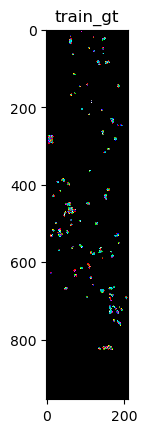

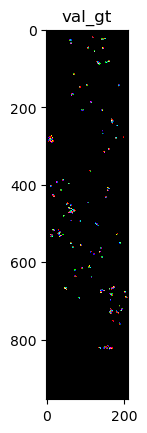

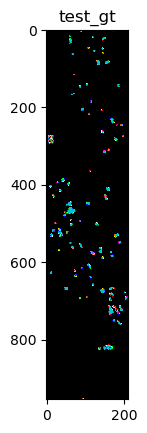

In [15]:
## display sampling info
sample_report = f"{'class': ^10}{'train_num':^10}{'val_num': ^10}{'test_num': ^10}{'total': ^10}\n"
for i in np.unique(label):
    if i == 0: continue
    sample_report += f"{i: ^10}{(train_gt==i).sum(): ^10}{(val_gt==i).sum(): ^10}{(test_gt==i).sum(): ^10}{(label==i).sum(): ^10}\n"
sample_report += f"{'total': ^10}{np.count_nonzero(train_gt): ^10}{np.count_nonzero(val_gt): ^10}{np.count_nonzero(test_gt): ^10}{np.count_nonzero(label): ^10}"
print(sample_report)
spectral.imshow(classes=train_gt, title='train_gt')
spectral.imshow(classes=val_gt, title='val_gt')
spectral.imshow(classes=test_gt, title='test_gt')

    sample_report = f"{'class': ^10}{'train_num':^10}{'val_num': ^10}{'test_num': ^10}{'total': ^10}\n"

这一行创建了一个字符串 sample_report，用于存储数据集划分的信息。它设置了表头，包括类别、训练数据数量、验证数据数量、测试数据数量和总数，这些信息将在下面的循环中填充。

    for i in np.unique(label):
        if i == 0: continue
        sample_report += f"{i: ^10}{(train_gt==i).sum(): ^10}{(val_gt==i).sum(): ^10}{(test_gt==i).sum(): ^10}{(label==i).sum(): ^10}\n"
    
这个循环遍历数据集中的每个类别。对于每个类别，它计算该类别在训练数据、验证数据和测试数据中的像素数量，然后将这些信息添加到 sample_report 中。

    sample_report += f"{'total': ^10}{np.count_nonzero(train_gt): ^10}{np.count_nonzero(val_gt): ^10}{np.count_nonzero(test_gt): ^10}{np.count_nonzero(label): ^10}"

这一行计算并添加了总体的像素数量信息到 sample_report 中。

    print(sample_report)

这一行打印了 sample_report，显示了数据集划分的信息。

    spectral.imshow(classes=train_gt, title='train_gt')
    spectral.imshow(classes=val_gt, title='val_gt')
    spectral.imshow(classes=test_gt, title='test_gt')

这三行使用 spectral.imshow 函数分别可视化了训练数据、验证数据和测试数据的类别地图，其中 classes 参数指定了类别地图数据，title 参数指定了图像的标题。

In [16]:
class PatchSet(Dataset):
    """ Generate 3D patch from hyperspectral dataset """
    def __init__(self, data, gt, patch_size, is_pred=False):
        """
        Args:
            data: 3D hyperspectral image
            gt: 2D array of labels
            patch_size: int, size of the 3D patch
            is_pred: bool, create data without label for prediction (default False) 

        """
        super(PatchSet, self).__init__()
        self.is_pred = is_pred
        self.patch_size = patch_size
        p = self.patch_size // 2
        self.data = np.pad(data,((p,p),(p,p),(0,0)),'constant',constant_values = 0)
        if is_pred:
            gt = np.ones_like(gt)
        self.label = np.pad(gt,(p,p),'constant',constant_values = 0)
        x_pos, y_pos = np.nonzero(gt)
        x_pos, y_pos = x_pos + p, y_pos + p   ##indices after padding
        self.indices = np.array([(x,y) for x,y in zip(x_pos, y_pos)])
        if not is_pred:
            np.random.shuffle(self.indices)

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, i):
        x, y = self.indices[i]
        x1, y1 = x - self.patch_size // 2, y - self.patch_size // 2
        x2, y2 = x1 + self.patch_size, y1 + self.patch_size
        data = self.data[x1:x2, y1:y2]
        label = self.label[x, y]
        data = np.asarray(data, dtype='float32').transpose((2, 0, 1))
        label = np.asarray(label, dtype='int64')
        data = torch.from_numpy(data)
        label = torch.from_numpy(label)
        if self.is_pred:
            return data
        else: return data, label


     class PatchSet(Dataset):
        """ Generate 3D patch from hyperspectral dataset """
        def __init__(self, data, gt, patch_size, is_pred=False):
            """
            Args:
                data: 3D hyperspectral image
                gt: 2D array of labels
                patch_size: int, size of the 3D patch
                is_pred: bool, create data without label for prediction (default False) 
            """
            super(PatchSet, self).__init__()

这里定义了一个名为 PatchSet 的自定义数据集类，它继承自 torch.utils.data.Dataset 类。在 __init__ 方法中，它接受 data（3D高光谱图像）、gt（2D标签数组）、patch_size（3D块的大小）和 is_pred（一个布尔值，用于指示是否为预测创建不带标签的数据）作为参数。

        self.is_pred = is_pred
        self.patch_size = patch_size
        p = self.patch_size // 2
        self.data = np.pad(data,((p,p),(p,p),(0,0)),'constant',constant_values = 0)
这里将输入的 is_pred 和 patch_size 存储在对象的属性中，并对输入的 data 进行填充，以便在边界周围添加额外的值。

        if is_pred:
            gt = np.ones_like(gt)
        self.label = np.pad(gt,(p,p),'constant',constant_values = 0)
如果 is_pred 为 True，则将标签 gt 替换为全1的数组；然后对标签进行填充，以便在边界周围添加额外的值。

        x_pos, y_pos = np.nonzero(gt)
        x_pos, y_pos = x_pos + p, y_pos + p   ##indices after padding
        self.indices = np.array([(x,y) for x,y in zip(x_pos, y_pos)])
        if not is_pred:
            np.random.shuffle(self.indices)
这里获取非零元素的索引，对索引进行调整以适应填充后的标签，并将这些调整后的索引存储在 self.indices 中。如果 is_pred 不为 True，则对索引进行随机打乱。

    def __len__(self):
        return len(self.indices)
__len__ 方法返回数据集中的样本数量，这里是 indices 的长度。

    def __getitem__(self, i):
        x, y = self.indices[i]
        x1, y1 = x - self.patch_size // 2, y - self.patch_size // 2
        x2, y2 = x1 + self.patch_size, y1 + self.patch_size
        data = self.data[x1:x2, y1:y2]
        label = self.label[x, y]
        data = np.asarray(data, dtype='float32').transpose((2, 0, 1))
        label = np.asarray(label, dtype='int64')
        data = torch.from_numpy(data)
        label = torch.from_numpy(label)
        if self.is_pred:
            return data
        else: return data, label
__getitem__ 方法用于获取数据集中的单个样本。它根据索引 i 获取相应位置的块，并将其转换为适当的数据类型（float32 和 int64），然后返回数据和标签。如果 is_pred 为 True，则只返回数据，否则返回数据和标签。

In [17]:
##create dataset and dataloader
train_data = PatchSet(data, train_gt, PATCH_SIZE)
val_data = PatchSet(data, val_gt, PATCH_SIZE)
all_data = PatchSet(data, label, PATCH_SIZE,is_pred = True)
train_loader = DataLoader(train_data,BATCH_SIZE,shuffle= True)
val_loader = DataLoader(val_data,BATCH_SIZE,shuffle= True)
all_loader = DataLoader(all_data,BATCH_SIZE,shuffle= False)

以上代码段创建了三个数据集（train_data、val_data 和 all_data）和三个对应的数据加载器（train_loader、val_loader 和 all_loader）。让我解释一下这段代码的作用：

    train_data = PatchSet(data, train_gt, PATCH_SIZE)
这里创建了一个名为 train_data 的数据集，它使用 PatchSet 类来生成训练数据。data 是输入的3D高光谱图像，train_gt 是训练数据的标签，PATCH_SIZE 是3D块的大小。

    val_data = PatchSet(data, val_gt, PATCH_SIZE)
这里创建了一个名为 val_data 的数据集，它使用 PatchSet 类来生成验证数据。它与 train_data 类似，但使用了不同的标签 val_gt。

    all_data = PatchSet(data, label, PATCH_SIZE, is_pred=True)
这里创建了一个名为 all_data 的数据集，它使用 PatchSet 类来生成所有数据（包括训练和验证）。is_pred=True 表示这是用于预测的数据，因此不包含标签。

    train_loader = DataLoader(train_data, BATCH_SIZE, shuffle=True)
这里创建了一个名为 train_loader 的数据加载器，它使用 DataLoader 类来加载训练数据集 train_data。BATCH_SIZE 是批处理大小，shuffle=True 表示在每个时期之前对数据进行洗牌。

    val_loader = DataLoader(val_data, BATCH_SIZE, shuffle=True)
这里创建了一个名为 val_loader 的数据加载器，它使用 DataLoader 类来加载验证数据集 val_data。它与 train_loader 类似，但用于验证数据。

    all_loader = DataLoader(all_data, BATCH_SIZE, shuffle=False)
这里创建了一个名为 all_loader 的数据加载器，它使用 DataLoader 类来加载所有数据集 all_data。与 train_loader 和 val_loader 不同，shuffle=False 表示不对数据进行洗牌。

In [18]:
d,g=train_data.__getitem__(0)
d.shape,g

(torch.Size([15, 25, 25]), tensor(3))

d 是数据集中第一个样本的数据，它是一个包含高光谱图像块的张量。根据你的代码，你的数据集中的每个样本都是一个大小为 PATCH_SIZE x PATCH_SIZE x NUM_BANDS 的高光谱图像块，因此 d 的形状应该是 (NUM_BANDS, PATCH_SIZE, PATCH_SIZE)。

g 是数据集中第一个样本的标签，它是一个整数张量，表示该块的类别或标签。

In [19]:
## Defination of HybridSN
class HybridSN(nn.Module):
    def __init__(self, in_chs, patch_size, class_nums):
        super().__init__()
        self.in_chs = in_chs
        self.patch_size = patch_size
        self.conv1 = nn.Sequential(
                    nn.Conv3d(in_channels=1,out_channels=8,kernel_size=(7, 3, 3)),
                    nn.ReLU(inplace=True))
        self.conv2 = nn.Sequential(
                    nn.Conv3d(in_channels=8,out_channels=16,kernel_size=(5, 3, 3)),
                    nn.ReLU(inplace=True))
            
        self.conv3 = nn.Sequential(
                    nn.Conv3d(in_channels=16,out_channels=32,kernel_size=(3, 3, 3)),
                    nn.ReLU(inplace=True))
        
        self.x1_shape = self.get_shape_after_3dconv()
        # print(self.x1_shape)
        self.conv4 = nn.Sequential(
                    nn.Conv2d(in_channels=self.x1_shape[1]*self.x1_shape[2],out_channels=64,kernel_size=(3, 3)),
                    nn.ReLU(inplace=True))
        self.x2_shape = self.get_shape_after_2dconv()
        
        # print(self.x2_shape)
        self.dense1 = nn.Sequential(
                    nn.Linear(self.x2_shape,256),
                    nn.ReLU(inplace=True),
                    nn.Dropout(p=0.4))
        
        self.dense2 = nn.Sequential(
                    nn.Linear(256,128),
                    nn.ReLU(inplace=True),
                    nn.Dropout(p=0.4))
        
        self.dense3 = nn.Sequential(
                    nn.Linear(128,class_nums)
                   )
    
    def get_shape_after_2dconv(self):
        x = torch.zeros((1, self.x1_shape[1]*self.x1_shape[2], self.x1_shape[3], self.x1_shape[4]))
        with torch.no_grad():
            x = self.conv4(x)
            print
        return x.shape[1]*x.shape[2]*x.shape[3]
    
    def get_shape_after_3dconv(self):
        x = torch.zeros((1, 1, self.in_chs, self.patch_size, self.patch_size))
        with torch.no_grad():
            x = self.conv1(x)
            x = self.conv2(x)
            x = self.conv3(x)
        return x.shape
    
    def forward(self, X):
        X = X.unsqueeze(1)
        x = self.conv1(X)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.shape[0],x.shape[1]*x.shape[2],x.shape[3],x.shape[4])
        # print(x.shape)
        x = self.conv4(x)
        x = x.contiguous().view(x.shape[0], -1)
        # print(x.shape)
        x = self.dense1(x)
        x = self.dense2(x)
        out = self.dense3(x)
        return out

In [20]:
NUM_CLASS = int(NUM_CLASS)
net = HybridSN(N_PCA,PATCH_SIZE,class_nums=NUM_CLASS)

In [21]:
summary(net, input_size=(1,N_PCA,PATCH_SIZE,PATCH_SIZE),col_names=['num_params','kernel_size','mult_adds','input_size','output_size'],col_width=10,row_settings=['var_names'],depth=4)

Layer (type (var_name))                  Param #    Kernel Shape Mult-Adds  Input Shape Output Shape
HybridSN (HybridSN)                      --         --         --         [1, 15, 25, 25] [1, 7]
├─Sequential (conv1)                     --         --         --         [1, 1, 15, 25, 25] [1, 8, 9, 23, 23]
│    └─Conv3d (0)                        512        [7, 3, 3]  2,437,632  [1, 1, 15, 25, 25] [1, 8, 9, 23, 23]
│    └─ReLU (1)                          --         --         --         [1, 8, 9, 23, 23] [1, 8, 9, 23, 23]
├─Sequential (conv2)                     --         --         --         [1, 8, 9, 23, 23] [1, 16, 5, 21, 21]
│    └─Conv3d (0)                        5,776      [5, 3, 3]  12,736,080 [1, 8, 9, 23, 23] [1, 16, 5, 21, 21]
│    └─ReLU (1)                          --         --         --         [1, 16, 5, 21, 21] [1, 16, 5, 21, 21]
├─Sequential (conv3)                     --         --         --         [1, 16, 5, 21, 21] [1, 32, 3, 19, 19]
│    └─Conv3d (0)       

以上代码是一个基于 PyTorch 深度学习框架的神经网络模型。

1. `__init__` 方法：这是 Python 类中的初始化方法，在创建类的实例时被调用。在这个方法中，定义了神经网络的各个层。下面是每个部分的解释：

   - `self.get_shape_after_3dconv()`：调用了一个辅助方法，用于获取3D卷积层的输出形状。
   
   - `self.conv4`：定义了一个包含了一个2D卷积层和ReLU激活函数的序列。这个卷积层将3D卷积层的输出进行二维卷积操作。
   
   - `self.x2_shape = self.get_shape_after_2dconv()`：调用了另一个辅助方法，用于获取2D卷积层的输出形状。
   
   - `self.dense1`、`self.dense2`、`self.dense3`：定义了三个全连接层，分别包含了线性变换、ReLU激活函数和Dropout操作。

2. `get_shape_after_2dconv` 方法：这个方法用于获取2D卷积层的输出形状。它创建了一个与输入形状相同的张量，并通过卷积层计算输出形状。

3. `get_shape_after_3dconv` 方法：这个方法用于获取3D卷积层的输出形状。它创建了一个与输入形状相同的张量，并通过卷积层计算输出形状。

4. `forward` 方法：这个方法定义了数据在模型中的前向传播过程。它通过卷积层和全连接层对输入数据进行处理，并返回最终的输出结果。

5. `net` 实例化：在最后，通过 `HybridSN` 类实例化了一个名为 `net` 的模型，同时使用 `summary` 方法对模型进行了摘要打印，显示了模型的结构和参数数量等信息。

综上所述，以上代码定义了一个混合卷积神经网络模型，其中包括了3D卷积层、2D卷积层和全连接层，用于处理高光谱图像数据。希望这些解释可以帮助你更好地理解这个模型的结构和功能。

Training::   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch 0/100 loss:0.0075639668503611765  acc:0.1857707509881423


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 1/100 loss:0.006185272308520492  acc:0.3386034255599473


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 2/100 loss:0.0053364671423187056  acc:0.5138339920948617


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 3/100 loss:0.004255648658209639  acc:0.5968379446640316


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 4/100 loss:0.0036870509739449844  acc:0.7035573122529645


  0%|          | 0/1 [00:00<?, ?it/s]

epoch 4/100  val_acc:0.849802371541502


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 5/100 loss:0.002586461574192575  acc:0.7878787878787878


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 6/100 loss:0.0018788460293620315  acc:0.8432147562582345


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 7/100 loss:0.0014694133609022863  acc:0.8787878787878788


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 8/100 loss:0.0008066286761141891  acc:0.9288537549407114


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 9/100 loss:0.0006129598939528736  acc:0.9433465085638999


  0%|          | 0/1 [00:00<?, ?it/s]

epoch 9/100  val_acc:0.9407114624505929


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 10/100 loss:0.000707479451484831  acc:0.9472990777338604


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 11/100 loss:0.00036626508427545804  acc:0.9749670619235836


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 12/100 loss:0.00022111054171215403  acc:0.9868247694334651


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 13/100 loss:0.00017135927995988345  acc:0.9868247694334651


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 14/100 loss:8.846473130391364e-05  acc:0.994729907773386


  0%|          | 0/1 [00:00<?, ?it/s]

epoch 14/100  val_acc:0.9920948616600791


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 15/100 loss:7.871950317630655e-05  acc:0.9934123847167325


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 16/100 loss:4.482886303653045e-05  acc:0.9986824769433466


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 17/100 loss:5.534347159019886e-05  acc:0.9934123847167325


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 18/100 loss:3.8003093748303115e-05  acc:0.9960474308300395


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 19/100 loss:3.857244228225137e-05  acc:0.9960474308300395


  0%|          | 0/1 [00:00<?, ?it/s]

epoch 19/100  val_acc:0.9881422924901185


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 20/100 loss:0.0001488809764620815  acc:0.9920948616600791


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 21/100 loss:0.00017593542055002314  acc:0.9894598155467721


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 22/100 loss:3.211607491506732e-05  acc:0.997364953886693


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 23/100 loss:0.00011832511226728813  acc:0.9881422924901185


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 24/100 loss:2.6901908420095015e-05  acc:0.9986824769433466


  0%|          | 0/1 [00:00<?, ?it/s]

epoch 24/100  val_acc:0.9881422924901185


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 25/100 loss:9.092465024662347e-05  acc:0.997364953886693


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 26/100 loss:4.3660667645149864e-05  acc:0.994729907773386


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 27/100 loss:8.340758469068643e-05  acc:0.994729907773386


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 28/100 loss:4.8389811711741686e-05  acc:0.9960474308300395


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 29/100 loss:2.178510838729355e-05  acc:0.9986824769433466


  0%|          | 0/1 [00:00<?, ?it/s]

epoch 29/100  val_acc:0.9881422924901185


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 30/100 loss:6.453072951618233e-05  acc:0.997364953886693


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 31/100 loss:2.6566262954504907e-05  acc:0.9986824769433466


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 32/100 loss:5.489557475951035e-05  acc:0.9960474308300395


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 33/100 loss:1.4176554806108374e-05  acc:0.9986824769433466


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 34/100 loss:3.7096086791342266e-05  acc:0.997364953886693


  0%|          | 0/1 [00:00<?, ?it/s]

epoch 34/100  val_acc:0.9881422924901185


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 35/100 loss:1.975753877130343e-05  acc:0.9986824769433466


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 36/100 loss:7.40812014057074e-06  acc:1.0


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 37/100 loss:4.144406930220771e-05  acc:0.9986824769433466


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 38/100 loss:9.588718387311783e-06  acc:1.0


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 39/100 loss:2.226615352224809e-05  acc:0.9986824769433466


  0%|          | 0/1 [00:00<?, ?it/s]

epoch 39/100  val_acc:0.9881422924901185


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 40/100 loss:4.578480246686652e-06  acc:1.0


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 41/100 loss:8.075856339868663e-06  acc:1.0


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 42/100 loss:3.3931166245890427e-06  acc:1.0


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 43/100 loss:5.967177761097749e-06  acc:1.0


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 44/100 loss:1.0702444291986495e-05  acc:0.9986824769433466


  0%|          | 0/1 [00:00<?, ?it/s]

epoch 44/100  val_acc:0.9881422924901185


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 45/100 loss:3.3140740721156434e-06  acc:1.0


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 46/100 loss:3.289564850719275e-06  acc:1.0


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 47/100 loss:7.362481039778203e-06  acc:1.0


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 48/100 loss:1.4829009001993614e-06  acc:1.0


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 49/100 loss:2.4135460726160933e-06  acc:1.0


  0%|          | 0/1 [00:00<?, ?it/s]

epoch 49/100  val_acc:0.9881422924901185


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 50/100 loss:1.1841561007209132e-06  acc:1.0


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 51/100 loss:1.7478728325784756e-06  acc:1.0


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 52/100 loss:1.387600512817448e-06  acc:1.0


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 53/100 loss:4.102305421109983e-06  acc:1.0


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 54/100 loss:9.424032157836715e-07  acc:1.0


  0%|          | 0/1 [00:00<?, ?it/s]

epoch 54/100  val_acc:0.9881422924901185


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 55/100 loss:9.095349160577655e-07  acc:1.0


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 56/100 loss:1.15455923066996e-06  acc:1.0


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 57/100 loss:1.551255320179815e-06  acc:1.0


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 58/100 loss:6.158009238359525e-06  acc:1.0


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 59/100 loss:4.552591756803421e-06  acc:1.0


  0%|          | 0/1 [00:00<?, ?it/s]

epoch 59/100  val_acc:0.9881422924901185


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 60/100 loss:1.2764551603800969e-06  acc:1.0


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 61/100 loss:9.015987827215585e-07  acc:1.0


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 62/100 loss:1.196453974128864e-06  acc:1.0


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 63/100 loss:5.795537374563373e-06  acc:0.9986824769433466


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 64/100 loss:1.8712090759639959e-06  acc:1.0


  0%|          | 0/1 [00:00<?, ?it/s]

epoch 64/100  val_acc:0.9881422924901185


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 65/100 loss:5.40934917702596e-07  acc:1.0


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 66/100 loss:6.648281361227941e-07  acc:1.0


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 67/100 loss:1.4167231898257884e-06  acc:1.0


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 68/100 loss:5.052223936127e-05  acc:0.9986824769433466


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 69/100 loss:2.1556858088372075e-06  acc:1.0


  0%|          | 0/1 [00:00<?, ?it/s]

epoch 69/100  val_acc:0.9881422924901185


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 70/100 loss:2.857216336912867e-05  acc:0.997364953886693


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 71/100 loss:2.6384950998915317e-06  acc:1.0


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 72/100 loss:9.421920692192314e-06  acc:0.9986824769433466


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 73/100 loss:5.968088271941165e-07  acc:1.0


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 74/100 loss:3.8279487879649885e-06  acc:1.0


  0%|          | 0/1 [00:00<?, ?it/s]

epoch 74/100  val_acc:0.9841897233201581


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 75/100 loss:1.0283862074041968e-05  acc:0.9986824769433466


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 76/100 loss:1.9463477023553264e-05  acc:0.9986824769433466


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 77/100 loss:3.2991160836797184e-06  acc:1.0


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 78/100 loss:2.1243835923633732e-05  acc:0.9986824769433466


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 79/100 loss:1.1383500612771558e-05  acc:0.9986824769433466


  0%|          | 0/1 [00:00<?, ?it/s]

epoch 79/100  val_acc:0.9881422924901185


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 80/100 loss:7.276974982865479e-06  acc:1.0


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 81/100 loss:7.883114976457495e-06  acc:1.0


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 82/100 loss:1.0087636571833974e-05  acc:0.9986824769433466


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 83/100 loss:1.1811587896335463e-06  acc:1.0


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 84/100 loss:3.869119894780385e-06  acc:1.0


  0%|          | 0/1 [00:00<?, ?it/s]

epoch 84/100  val_acc:0.9881422924901185


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 85/100 loss:5.131691636512122e-07  acc:1.0


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 86/100 loss:2.2260030214361875e-06  acc:1.0


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 87/100 loss:1.1656725609230862e-06  acc:1.0


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 88/100 loss:1.096411809700692e-06  acc:1.0


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 89/100 loss:2.10509907603951e-06  acc:1.0


  0%|          | 0/1 [00:00<?, ?it/s]

epoch 89/100  val_acc:0.9881422924901185


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 90/100 loss:1.4441793466082558e-06  acc:1.0


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 91/100 loss:2.712621722061786e-06  acc:1.0


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 92/100 loss:2.402644492860648e-06  acc:1.0


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 93/100 loss:9.735325856053925e-07  acc:1.0


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 94/100 loss:2.702142598401333e-06  acc:1.0


  0%|          | 0/1 [00:00<?, ?it/s]

epoch 94/100  val_acc:0.9881422924901185


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 95/100 loss:5.921510112476787e-07  acc:1.0


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 96/100 loss:3.686102819961848e-07  acc:1.0


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 97/100 loss:6.769864002966024e-07  acc:1.0


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 98/100 loss:1.1766215959312001e-05  acc:0.9986824769433466


  0%|          | 0/3 [00:00<?, ?it/s]

epoch 99/100 loss:1.4167619278293706e-06  acc:1.0


  0%|          | 0/1 [00:00<?, ?it/s]

epoch 99/100  val_acc:0.9881422924901185
Stop in epoch 99


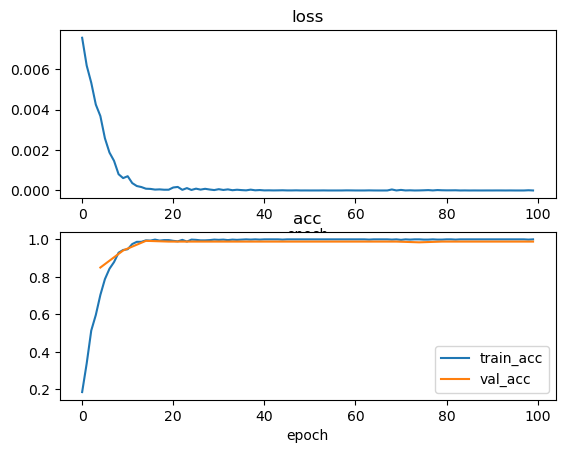

In [22]:
## training the model
device = torch.device(DEVICE if DEVICE>=0 and torch.cuda.is_available() else 'cpu')
loss_list = []
acc_list = []
val_acc_list = []
val_epoch_list = []

model = HybridSN(N_PCA,PATCH_SIZE,class_nums=NUM_CLASS)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(),LR,weight_decay=WEIGHT_DECAY)
loss_func = nn.CrossEntropyLoss()
batch_num = len(train_loader)
train_num = train_loader.dataset.__len__()
val_num = val_loader.dataset.__len__()

fig = plt.figure()
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
try:
    for e in tqdm(range(EPOCH), desc="Training:"):
        model.train()
        avg_loss = 0.
        train_acc = 0
        for batch_idx, (data, target) in tqdm(enumerate(train_loader),total=batch_num):
            data,target = data.to(device),target.to(device)
            optimizer.zero_grad()
            out = model(data)
            target = target - 1  ## class 0 in out is class 1 in target
            loss = loss_func(out,target)
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            _,pred = torch.max(out,dim=1)
            train_acc += (pred == target).sum().item()
        loss_list.append(avg_loss/train_num)
        acc_list.append(train_acc/train_num)
        print(f"epoch {e}/{EPOCH} loss:{loss_list[e]}  acc:{acc_list[e]}")
        ## valuation
        if (e+1)%VAL_EPOCH == 0 or (e+1)==EPOCH:
            val_acc =0
            model.eval()
            for batch_idx, (data, target) in tqdm(enumerate(val_loader),total=len(val_loader)):
                data,target = data.to(device),target.to(device)
                out = model(data)
                target = target - 1  ## class 0 in out is class 1 in target
                _,pred = torch.max(out,dim=1)
                val_acc += (pred == target).sum().item()
            val_acc_list.append(val_acc/val_num)
            val_epoch_list.append(e)
            print(f"epoch {e}/{EPOCH}  val_acc:{val_acc_list[-1]}")
            save_name = os.path.join(SAVE_PATH, f"epoch_{e}_acc_{val_acc_list[-1]:.4f}.pth")
            torch.save(model.state_dict(),save_name)
    ax1.plot(np.arange(e+1),loss_list)
    ax1.set_title('loss')
    ax1.set_xlabel('epoch')
    ax2.plot(np.arange(e+1),acc_list,label = 'train_acc')
    ax2.plot(val_epoch_list,val_acc_list,label = 'val_acc')
    ax2.set_title('acc')
    ax2.set_xlabel('epoch')
    ax2.legend()
except Exception as exc:
    print(exc)
finally: 
    print(f'Stop in epoch {e}')


以上代码是用于训练混合卷积神经网络模型的部分。

device 和 model.to(device)：这部分代码用于将模型移动到 GPU 或 CPU 上进行训练。如果 GPU 可用且 DEVICE 大于等于 0，则将模型移动到 GPU 上，否则使用 CPU。

optimizer 和 loss_func：定义了优化器和损失函数。优化器使用 Adam 优化算法，损失函数使用交叉熵损失函数。

训练循环：使用 for 循环对模型进行训练。在每个 epoch 中，模型首先设置为训练模式（model.train()），然后对训练数据集进行迭代。在每个迭代中，计算模型输出和损失，然后进行反向传播和优化器更新参数。同时计算并记录平均损失和训练精度。

模型验证：在每个指定的验证周期（VAL_EPOCH）或者在最后一个 epoch 后，对模型进行验证。在验证过程中，模型设置为评估模式（model.eval()），然后对验证数据集进行迭代。计算验证精度并记录下来。

可视化训练过程：使用 Matplotlib 库将训练过程中的损失和精度进行可视化展示。

异常处理：使用 try 和 except 块来捕获可能出现的异常，并打印异常信息。

最终输出：在训练结束或者发生异常时，打印出停止训练的信息。

综上所述，以上代码是一个完整的混合卷积神经网络模型的训练过程，包括了模型的初始化、设备选择、损失函数、优化器、训练循环、模型验证、训练过程可视化等步骤。

In [23]:
## get best model path and del other models
def get_best_model(acc_list, epoch_list, save_path):
    """get best model path by valuation list

    Args:
        acc_list (list): list of valuation accuracy
        epoch_list (list): list of valuation epoch
        save_path (str): path of save dir

    Returns:
        best_model_path: path of best model
    """
    acc_list = np.array(acc_list)
    epoch_list = np.array(epoch_list)
    best_index = np.argwhere(acc_list==np.max(acc_list))[-1].item()
    best_epoch = epoch_list[best_index]
    best_acc = acc_list[best_index]
    file_name = f"epoch_{best_epoch}_acc_{best_acc:.4f}.pth"
    best_model_path=os.path.join(save_path, file_name)
    print(f"best model:{file_name}")
    ##del save model except best model
    for f in os.listdir(save_path):
        if f[-3:]=='pth' and os.path.join(save_path,f)!=best_model_path:
            os.remove(os.path.join(save_path,f))
    return best_model_path

以上代码是一个函数，用于根据验证精度列表选择最佳模型，并删除其他模型文件。

get_best_model 函数接受三个参数：acc_list（验证精度列表）、epoch_list（验证 epoch 列表）和 save_path（模型保存路径）。

函数首先将 acc_list 和 epoch_list 转换为 NumPy 数组，以便后续处理。

接着，函数通过 np.argwhere(acc_list==np.max(acc_list))[-1].item() 找到验证精度列表中最大值所对应的索引，并获取最佳模型的 epoch 和验证精度。

然后，函数根据最佳 epoch 和验证精度拼接出最佳模型的文件名，并构建出最佳模型的完整路径 best_model_path。

接下来，函数遍历模型保存路径下的所有文件，如果文件是以 ".pth" 结尾的模型文件且不是最佳模型文件，则删除该文件。

最后，函数返回最佳模型的完整路径 best_model_path。

综上所述，以上函数的功能是根据验证精度列表选择最佳模型，并删除其他模型文件。

best model:epoch_14_acc_0.9921.pth


  0%|          | 0/783 [00:00<?, ?it/s]

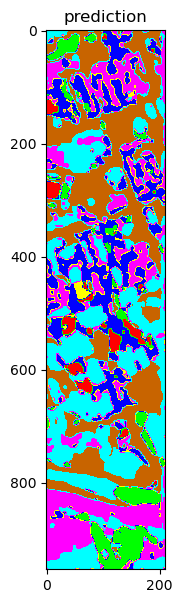

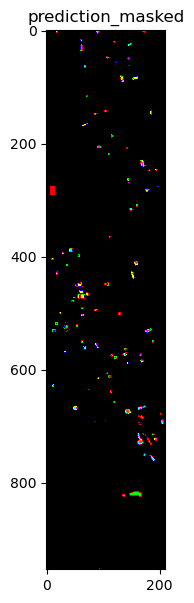

In [24]:
## inferring the whole image
##load best model
best_model_path = get_best_model(val_acc_list,val_epoch_list,SAVE_PATH)
best_model = HybridSN(N_PCA,PATCH_SIZE,class_nums=NUM_CLASS)
best_model.load_state_dict(torch.load(best_model_path))
## inference
best_model.to(device)
best_model.eval()
pred_map = []
for batch_idx, data in tqdm(enumerate(all_loader),total=len(all_loader)):
    data = data.to(device)
    target = best_model(data)
    _, pred = torch.max(target, dim = 1)
    pred_map += [np.array(pred.detach().cpu() + 1)]   ## class 0 in pred_map is class 1 in gt
pred_map = np.asarray(np.hstack(pred_map),dtype=np.uint8).reshape(label.shape[0],label.shape[1])
spectral.imshow(classes=pred_map,title='prediction',figsize=(7,7))
spectral.imshow(classes=pred_map*(label!=0),title='prediction_masked',figsize=(7,7))
spectral.save_rgb(os.path.join(SAVE_PATH,f"prediction.jpg"),pred_map,colors = spectral.spy_colors)
spectral.save_rgb(os.path.join(SAVE_PATH,f"prediction_masked.jpg"),pred_map*(label!=0),colors = spectral.spy_colors)

以上代码是用于推断整个图像的过程，包括加载最佳模型、进行推断、可视化推断结果并保存结果图片。

首先调用之前定义的 get_best_model 函数获取验证中表现最佳的模型路径 best_model_path。

接着创建一个新的混合卷积神经网络模型 best_model，并加载之前保存的最佳模型参数。

将模型移动到指定的设备上，并设置为评估模式。

然后对整个图像进行推断。通过迭代数据加载器 all_loader 中的数据，将数据传入模型中进行推断，并将推断结果保存在 pred_map 中。

将推断结果进行可视化展示，包括原始推断结果和去除背景的推断结果，并将可视化结果保存为图片文件。

In [25]:
## classfication report
test_pred = pred_map[test_gt!=0]
test_true = test_gt[test_gt!=0]

OA = accuracy_score(test_true,test_pred)
AA = recall_score(test_true,test_pred,average='macro')
kappa = cohen_kappa_score(test_true,test_pred)
report_log = F"OA: {OA}\nAA: {AA}\nKappa: {kappa}\n"
report_log += classification_report(test_true,test_pred,target_names=class_name,digits=4)
print(report_log)
fp = open(os.path.join(SAVE_PATH,'classfication_report.txt'),'w+')
fp.writelines(report_log)
fp.close()

OA: 0.9920948616600791
AA: 0.9920366403481754
Kappa: 0.9907467470620058
                           precision    recall  f1-score   support

            Grass-healthy     1.0000    1.0000    1.0000       207
           Grass-stressed     1.0000    0.9954    0.9977       219
                    Trees     0.9910    1.0000    0.9955       219
                    Water     1.0000    1.0000    1.0000       171
    Residential-buildings     1.0000    0.9686    0.9840       191
Non-residential-buildings     0.9959    0.9878    0.9918       245
                     Road     0.9670    0.9925    0.9796       266

                 accuracy                         0.9921      1518
                macro avg     0.9934    0.9920    0.9927      1518
             weighted avg     0.9923    0.9921    0.9921      1518



以上代码是用于生成分类报告的过程，包括计算准确率、召回率、Kappa 系数以及生成分类报告文本文件。

首先，从推断结果 pred_map 和测试集标签 test_gt 中提取出非背景类别的像素值，分别存储在 test_pred 和 test_true 中。

接着，使用 accuracy_score 函数计算整体精度（Overall Accuracy，OA），即所有类别的正确分类样本数占总样本数的比例。

使用 recall_score 函数计算平均召回率（Average Accuracy，AA），采用宏平均方式计算各个类别的召回率，并对各个类别的召回率取平均值。

使用 cohen_kappa_score 函数计算 Kappa 系数，用于评估分类器的性能，考虑了分类结果与随机分类结果之间的一致性。

构建分类报告文本 report_log，包括 OA、AA、Kappa 系数以及使用 classification_report 函数生成的详细分类报告，设置了每个类别的统计数字保留小数点后四位。

最后，将分类报告文本写入到文件 classfication_report.txt 中，并打印在控制台上。

综上所述，以上代码是用于生成分类报告的过程，包括计算准确率、召回率、Kappa 系数以及生成分类报告文本文件。